import gym
import d4rl # Import required to register environments
# import time 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
env = gym.make("hopper-expert-v0")
dataset = env.get_dataset()

NameError: name 'gym' is not defined

In [3]:
len(dataset['observations'])

NameError: name 'dataset' is not defined

In [4]:
data_array = np.array(dataset["rewards"][:10000])
neg_array = data_array[data_array<0]
neg_array.size

NameError: name 'np' is not defined

In [5]:
observations = torch.tensor(dataset['observations'])[:10000]
mean = observations.mean(dim=0)
std = observations.std(dim=0)
observations = (observations - mean)/std
actions = torch.tensor(dataset['actions'])[:10000]
# data = TensorPairDataset(observations,actions)

NameError: name 'torch' is not defined

In [6]:
observations

NameError: name 'observations' is not defined

In [7]:
env.reset()

NameError: name 'env' is not defined

In [8]:
dataset_N = {"observations":dataset["observations"][:10000],"actions":dataset["actions"][:10000]}
new_dataset = [dict(zip(dataset_N.keys(), values)) for values in zip(*dataset_N.values())]

# Print result
# print(new_dataset)


NameError: name 'dataset' is not defined

In [9]:
class P_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.network_m = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3))                                     
        self.network_s = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3))      
    def forward(self,state):
        self.mean = self.network_m(state)
        self.std = F.softplus(self.network_s(state)) + 1e-6
        # print(self.mean,self.std)
        
        normal_dist = torch.distributions.Normal(self.mean,self.std)
        raw_action = normal_dist.rsample()  # Use reparameterization trick
        
        # Map action to [-1, 1] using tanh
        action = torch.clamp(raw_action,min=-1,max=1)
        # print(self.mean,self.std)
        # Compute log probability of the sampled action
        log_prob = normal_dist.log_prob(raw_action) 
        # print(log_prob)
        log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
        # print(action)
        
        return action, log_prob

        
                    
           

NameError: name 'nn' is not defined

In [ ]:
class PM_Network(nn.Module):
    def __init__(self,input_size,output_size):
        super().__init__()
        self.action_network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3),
                                     nn.Tanh())                                     
        self.prob_network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,8),
                                     nn.Tanh(),
                                     nn.Linear(8,3),
                                     nn.Sigmoid())      
    def forward(self,state):
        
        
        # Map action to [-1, 1] using tanh
        action = self.action_network(state)
        log_prob = torch.log(self.prob_network(state) )
        
        log_prob = log_prob.sum(dim=-1, keepdim=True)  # Sum over action dimensions
        # print(action)
        
        return action, log_prob

        
                    
           

In [ ]:
class D_Network(nn.Module):
    def __init__(self,input_size):
        super(D_Network,self).__init__()
        self.network = nn.Sequential(nn.Linear(input_size,24),
                                     nn.Tanh(),
                                     nn.Linear(24,16),
                                     nn.Tanh(),
                                     nn.Linear(16,4),
                                     nn.Tanh(),
                                     nn.Linear(4,1),
                                     nn.Sigmoid())
    def forward(self,state,action):
        # print(state,action)
        # print("State shape:", state.shape, "Action shape:", action.shape)
        x = torch.cat((state, action.detach()), dim=-1)
        # print("combined input",x)
        self.output = self.network(x.float())

        return self.output
    
        



In [ ]:
Policy = PM_Network(11,3)

In [ ]:
Discriminator = D_Network(14)

In [ ]:
import random
from IPython.display import clear_output
import time
import copy

In [ ]:
def compute_kl_divergence(p_network_old, p_network_new, states):
    with torch.no_grad():
        old_probs = p_network_old.prob_network(states)
    new_probs = p_network_new.prob_network(states)
    
    kl = (old_probs * (torch.log(old_probs + 1e-8) - torch.log(new_probs + 1e-8))).sum(dim=-1)
    return kl.mean()

def train(dataset, epochs, traj_no, max_steps, P_network, D_network, lr_D, lr_P, lamda, beta, opt_func=torch.optim.Adam):
    state = torch.from_numpy(env.reset())
    
    D_losses = []
    P_losses = []
    KL_losses = []
    
    expert_trajectories = []
    for t in range(traj_no):
        idx = random.randint(0, len(dataset) - max_steps)
        expert_trajectories.append(dataset[idx:idx + max_steps])

    for epoch in range(epochs):
        Ex_aD_loss, Ex_eD_loss, Ex_P_loss, Ex_H_loss = 0, 0, 0, 0
        sample_trajectories = []

        # Clone the current policy network for KL divergence calculation
        P_network_old = PM_Network(11,3)
        P_network_old.load_state_dict(P_network.state_dict())
        P_network_old.eval()
        
        for path in range(traj_no):
            state = torch.from_numpy(env.reset())
            aD_loss, eD_loss, H_loss = 0, 0, 0
            current_trajectory = []
            
            for step in range(1, max_steps):
                action, log_prob = P_network(state.float())
                current_trajectory.append({"state": state, "actions": action, "log_prob": log_prob})
                
                temp_action = action
                next_state, reward, done, info = env.step(np.array(temp_action.detach()))
                
                exp_state = torch.Tensor(expert_trajectories[path][step]["observations"])
                exp_action = torch.Tensor(expert_trajectories[path][step]["actions"])
                
                aD_loss += torch.log(D_network(state.detach(), action.detach()) + 1e-8)
                eD_loss += torch.log(1 - D_network(exp_state, exp_action) + 1e-8)

                H_loss -= log_prob * torch.exp(log_prob).item()
                
                if done or step == max_steps - 1:
                    break
                state = torch.from_numpy(next_state)
            
            sample_trajectories.append(current_trajectory)
            Ex_aD_loss += aD_loss
            Ex_eD_loss += eD_loss
            Ex_H_loss += H_loss
        
        ### Update Discriminator ###
        Ex_aD_loss /= traj_no
        Ex_eD_loss /= traj_no
        total_D_loss = -(Ex_aD_loss + Ex_eD_loss)
        
        opt_D = opt_func(D_network.parameters(), lr_D)
        opt_D.zero_grad()
        total_D_loss.backward()
        opt_D.step()
        clip_eps = 0.2  # Clipping threshold, usually 0.1 to 0.3
        # -------------- Update Policy -------------- 
        Ex_P_loss = 0
        all_states = []
        all_old_log_probs = []
        all_advantages = []
        
        for traj in sample_trajectories:
            traj_P_loss = 0
            for idx, step in enumerate(traj):
                Q = 0.1
                for jdx in range(idx + 1, len(traj)):
                    temp = D_network(traj[jdx]['state'].detach(), traj[jdx]['actions'].detach())
                    Q += torch.log(temp + 1e-8).item()
                
                advantage = Q
                all_advantages.append(advantage)
                
                all_states.append(step['state'].float().unsqueeze(0))  # For KL calculation
                all_old_log_probs.append(step['log_prob'].detach().unsqueeze(0))  # Save old log_probs
                
        Ex_P_loss /= traj_no
        all_states = torch.cat(all_states, dim=0)
        all_old_log_probs = torch.cat(all_old_log_probs, dim=0)
        all_advantages = torch.tensor(all_advantages, dtype=torch.float32).unsqueeze(1)
        
        # Now recompute new log_probs with updated P_network
        new_actions, new_log_probs = P_network(all_states)
        
        # Compute the ratio
        ratios = torch.exp(new_log_probs - all_old_log_probs)
        
        # PPO clipped surrogate loss
        surr1 = ratios * all_advantages
        surr2 = torch.clamp(ratios, 1 - clip_eps, 1 + clip_eps) * all_advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        
        # KL divergence (optional, for monitoring)
        kl_div = compute_kl_divergence(P_network_old, P_network, all_states)
        
        total_P_loss = policy_loss + lamda * Ex_H_loss + beta * kl_div
        
        opt_P = opt_func(P_network.parameters(), lr_P)
        opt_P.zero_grad()
        total_P_loss.backward()
        opt_P.step()

        D_losses.append(total_D_loss.detach().item())
        P_losses.append(total_P_loss.detach().item())
        KL_losses.append(kl_div.detach().item())

        clear_output(wait=True)
        plt.plot(D_losses, label='Discriminator Loss')
        plt.plot(P_losses, label='Policy Loss')
        plt.plot(KL_losses, label='KL Divergence')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.grid(True)
        plt.legend()
        plt.show()
        time.sleep(0.1)

    return D_losses, P_losses, KL_losses


In [ ]:

def train(dataset,epochs,traj_no,max_steps,P_network,D_network,lr_D,lr_P,lamda,opt_func=torch.optim.SGD):
    state = torch.from_numpy(env.reset())
    # print(state.dtype)
    expert_trajectories =[]
    D_losses = []
    P_losses = []
    for t in range(traj_no):
        idx = random.randint(0,len(dataset)-max_steps)
        expert_trajectories.append(dataset[idx:idx+max_steps])

    for epoch in range(epochs):
        # print("Epoch No:",epoch)
        Ex_aD_loss = 0
        Ex_eD_loss = 0
        Ex_P_loss =0 
        Ex_H_loss=0
        # Trajectory Sampling
        sample_trajectories =[]
        for path in range(traj_no):
            state = torch.from_numpy(env.reset())
            aD_loss=0
            eD_loss=0
            H_loss=0
            current_trajectory=[]
            for step in range(1,max_steps):
                
                action, log_prob = P_network(state.float())
                current_trajectory.append({"state":state,"actions":action,"log_prob":log_prob})
                temp_action = action
                next_state,reward,done,info = env.step(np.array(temp_action.detach()))

                exp_state = torch.Tensor(expert_trajectories[path][step]["observations"])
                exp_action = torch.Tensor(expert_trajectories[path][step]["actions"])
                
                aD_loss += torch.log(D_network(state.detach(),action.detach())+1e-8)
                eD_loss += torch.log(1- D_network(exp_state,exp_action)+1e-8)

                H_loss-=log_prob*torch.exp(log_prob).item()
                
                if done or step==max_steps-1:
                    # eD_loss /= step
                    # aD_loss /= step
                    # P_loss /= step
                    break
                state = torch.from_numpy(next_state)
                
            sample_trajectories.append(current_trajectory)
                    

            Ex_aD_loss+=aD_loss
            Ex_eD_loss+=eD_loss
            Ex_H_loss += H_loss
        
        ### Updating Discriminator 
        # print("XX============UPDATE DISCRIMINATOR===============XX")
        Ex_aD_loss/=traj_no
        Ex_eD_loss/=traj_no
        total_D_loss = -(Ex_aD_loss + Ex_eD_loss)
        
        
        opt_D = opt_func(D_network.parameters(),lr_D)
        # print(Ex_aD_loss,Ex_eD_loss)
        # print("total D loss",total_D_loss)
        # print(list(D_network.parameters()))
        total_D_loss.backward()
        opt_D.step()
        opt_D.zero_grad()

        
        ## Updating the Policy
        # print("XX================UPDATE POLICY======================XX")
        Ex_P_loss=0
        
        for traj in sample_trajectories:
            traj_P_loss=0
            for idx,step in enumerate(traj):
                Q=0.1
                for jdx in range(idx+1,len(traj)):
                    temp = D_network(traj[jdx]['state'].detach(),traj[jdx]['actions'].detach())
                    # print("temp",temp)
                    Q+=torch.log(temp).item()
                    
                # print("Q:",Q)
                traj_P_loss-=step['log_prob']*Q
            
            Ex_P_loss+=traj_P_loss
        
                
        Ex_P_loss/=traj_no
        # Ex_H_loss/=traj_no
        # Ex_H_loss/=traj_no
        total_P_loss = (Ex_P_loss) + lamda*Ex_H_loss 
        # print("PLOss:",total_P_loss)
        opt_P = opt_func(P_network.parameters(),lr_P)
        total_P_loss.backward()
        opt_P.step()
        opt_P.zero_grad()
        # print("P descent happened!!")
        D_losses.append(total_D_loss.detach())
        P_losses.append(total_P_loss.detach())

        clear_output(wait=True)
    
        # Plot the losses
        plt.plot(D_losses, label='Discriminator Loss')
        plt.plot(P_losses, label='Policy Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.grid(True)
        plt.legend()
        plt.show()
    
        # Simulate time delay (you can remove this)
        time.sleep(0.1)

    return D_losses,P_losses
        
    
    

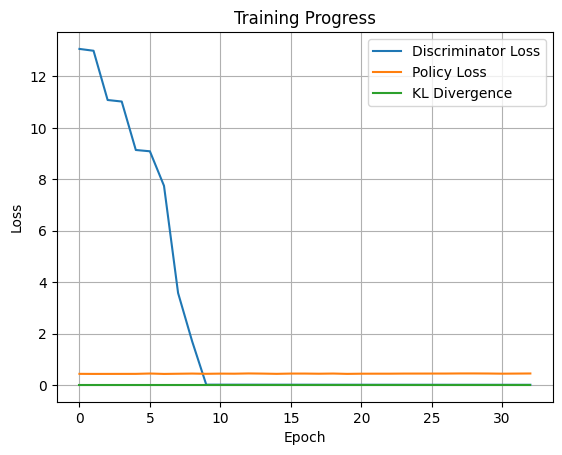

KeyboardInterrupt: 

In [ ]:
train(new_dataset,200,5,300,Policy,Discriminator,1e-2,1e-4,0.01,0.01)

In [ ]:
env.action_space

Box(-1.0, 1.0, (3,), float32)

In [ ]:
def test(model,D_network,episodes):
    env = gym.make("hopper-expert-v0")
    # state,info = env.reset()
    state = torch.from_numpy(env.reset())
    total_reward=0
    D_loss =0
    for ep in range(episodes):
       
        action, log_prob = model(state.float())
        temp_action = action
        next_state,reward,done,info = env.step(np.array(temp_action.detach()))
        D_loss += torch.log(D_network(state.detach(),action.detach())+1e-8).item()
        total_reward+=reward
        if done or ep==episodes-1:
            print(total_reward,ep)
            
            break
        state = torch.from_numpy(next_state)    
    env.close()
    return total_reward

In [ ]:
gail_history=[]
for i in range(200):
    gail_history.append(test(Policy,Discriminator,200))

43.80105989712036 35
43.671702663258365 35
42.04072596227476 34
43.69125670122167 35
45.87829355014439 36
42.14418727062621 34
43.78835513250115 35
42.10591751137702 34
44.012420507815996 35
43.97327982866645 35
44.02314724997769 35
43.78624063379483 35
45.41994376989026 36
43.97445505405502 35
43.94396599716357 35
45.8251298197011 36
45.68964562080159 36
41.94885192970535 34
44.01393654161862 35
43.70598398555298 35
43.74625168543724 35
45.704795713851524 36
43.63185167133187 35
43.98074973722397 35
43.95121387172831 35
43.63879318740729 35
45.82188515843185 36
43.87965939505195 35
43.66174665676302 35
43.97398800414916 35
45.72944385093949 36
43.861618990269015 35
45.72671492637148 36
45.69860015953079 36
44.03896520800545 35
45.54862861830897 36
43.595755723782005 35
45.78986976428363 36
42.14868557088299 34
43.86306011666653 35
42.162751171079854 34
45.55411157823444 36
43.79823644576431 35
42.248413721684656 34
45.55982950501165 36
45.508892112442496 36
43.6062042361642 35
45.4790

In [ ]:
Policy_random = PM_Network(11,3)
D_random = D_Network(14)

In [ ]:
random_history=[] 
for i in range(200):
    random_history.append(test(Policy_random,D_random,200))

6.129666583506093 13
5.894669035904131 13
6.155188433344526 13
5.964677273547094 13
5.913483276465588 13
6.032500269958781 13
5.833683466856446 13
6.070318390065305 13
6.167293617174607 13
6.0461970329085375 13
6.0759958797051485 13
6.040624348273444 13
6.016606260112912 13
5.938411373812702 13
5.933054390867824 13
6.032266546462682 13
6.058750028584091 13
5.965830193068197 13
6.031334471759777 13
5.949033665051245 13
5.835556200275528 13
6.04883606223315 13
6.123477892580725 13
6.101653765914892 13
6.155152006005546 13
5.9428792435708555 13
6.063686115679565 13
5.8117845012800045 13
6.037367946845579 13
6.0575623075864735 13
6.047600982632782 13
5.961328646426694 13
5.996939638795141 13
6.032136853033877 13
5.936801037210599 13
6.008393362960391 13
5.96154375702188 13
6.026365830033735 13
6.10003467313596 13
6.103454741573267 13
5.941021386397678 13
6.0942061783235015 13
5.913470968526913 13
5.837719589751899 13
6.047230072963162 13
5.835043317595052 13
5.948470125164705 13
6.06156851

In [ ]:
import matplotlib.pyplot as plt
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
def plot_two_series(y1, y2, x_label='Episodes', y_label='Total Reward', title='Graph of Two Series', legend1='Gail', legend2='No Gail'):
    x = range(len(y1))  # Assumes y1 and y2 have the same length
    plt.figure(figsize=(10, 5))
    window_size=5
    smoothed_y1 = moving_average(y1, window_size)
    smoothed_y2 = moving_average(y2, window_size)
    x_smooth = range(window_size - 1, len(y1))  # Adjust x for smoothed data
    
    plt.plot(x_smooth, smoothed_y1, label=f'{legend1} (SMA-{window_size})', color='blue', linewidth=2)
    plt.plot(x_smooth, smoothed_y2, label=f'{legend2} (SMA-{window_size})', color='orange', linewidth=2)
    # plt.plot(x, y1, label=legend1, marker='o')
    # plt.plot(x, y2, label=legend2, marker='x')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


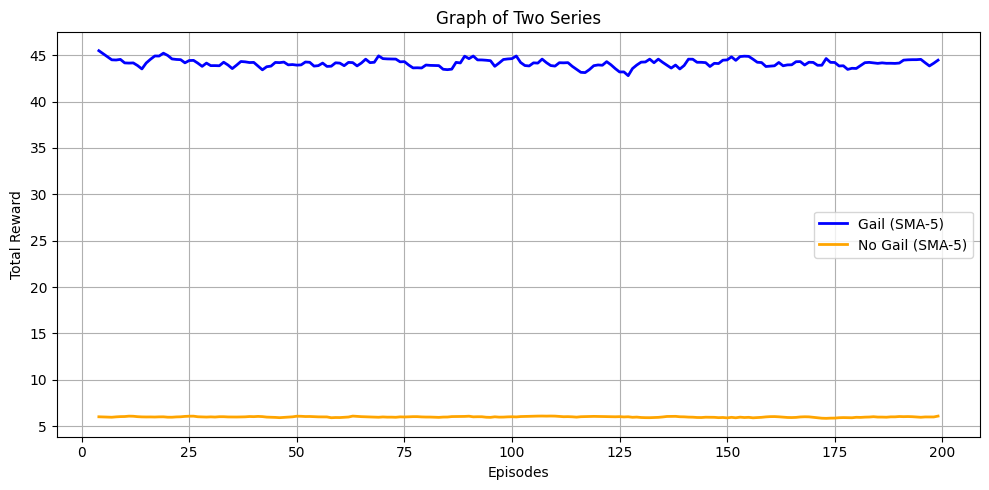

In [ ]:
plot_two_series(gail_history,random_history)